<a href="https://colab.research.google.com/github/Corry-Grodek/DataScience/blob/main/CorrGrodU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

#import data from the Github, and convert the Pos column to a category for later
url_bb = 'https://github.com/thedarredondo/data-science-fundamentals/raw/refs/heads/main/Data/basketball2324.csv'
bb_data = pd.read_csv(url_bb,dtype={'Pos':'category'})
bb_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


For this project I will use the NBA player statistics provided by Mr Arredondo. After looking through lots of different databases, I had a hard time finding a dataset that seemed like a good cantidate for a hierarchical model.

Once I had selected my data set, I thought it would be interesting to see how good different positions are at scoring free throws. I do not know much about basketball, but this seemed like a pretty easy to concept to work with.

In [4]:
#Covert the Position column into a numbered list with a dictionary so the model can process them
pos_idx = bb_data.Pos.cat.codes.values
pos_codes = bb_data.Pos.cat.categories
bb_coords = {"pos": pos_codes}

I thought it would probably be a good idea to look at my data before I try to do anything with it, so I used a violin plot to show the free throws attempted, and free throws scored. This plot shows that the amount of free throws attempted is indeed below the amount attempted, which makes sense.

<Axes: ylabel='FTA'>

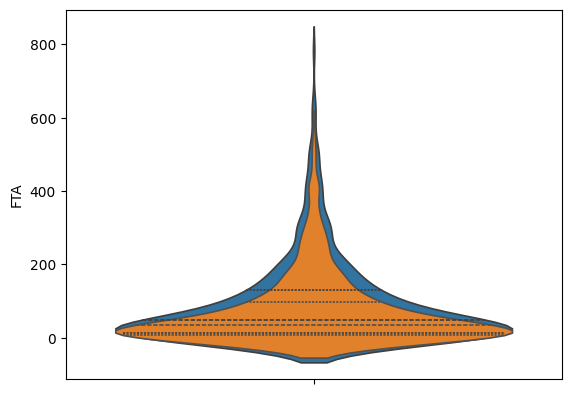

In [5]:
sns.violinplot(bb_data.FTA,inner='quart')
sns.violinplot(bb_data.FT,inner='quart')

For this first model I used the same priors and hyperpriors as the soccer players example in the Unit 4 notes.

In [6]:
with pm.Model(coords = bb_coords) as bb_model:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    _ = pm.Binomial('gs',
                    n = bb_data.FTA.values,
                    p = θ,
                    observed = bb_data.FT.values)

    idata_bb = pm.sample(target_accept = 0.95)

Output()

Output()

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

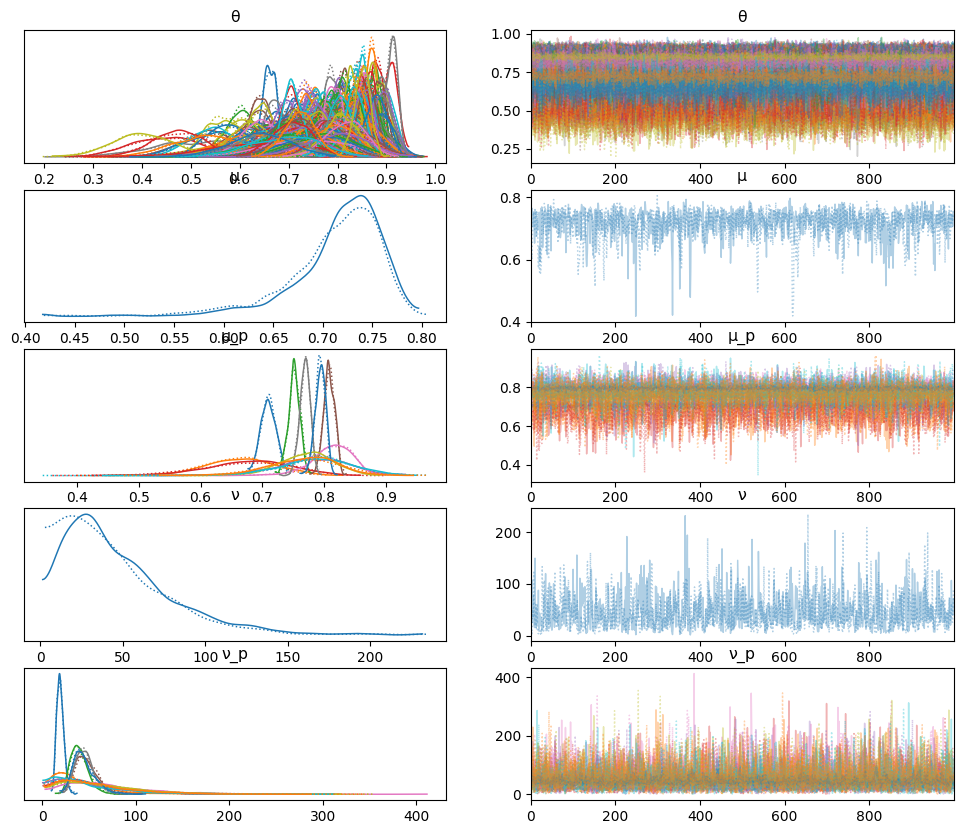

In [7]:
az.plot_trace(idata_bb)

<xarray.Dataset> Size: 10kB
Dimensions:  (θ_dim_0: 572, pos: 12)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 5kB 0 1 2 3 4 5 6 7 ... 565 566 567 568 569 570 571
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    θ        (θ_dim_0) float64 5kB 0.9994 1.002 1.002 0.9999 ... 1.01 1.005 1.0
    μ        float64 8B 1.003
    μ_p      (pos) float64 96B 0.9994 1.001 1.004 1.003 ... 1.001 1.0 1.003
    ν        float64 8B 1.004
    ν_p      (pos) float64 96B 1.001 1.001 1.003 1.001 ... 1.002 1.001 0.9999

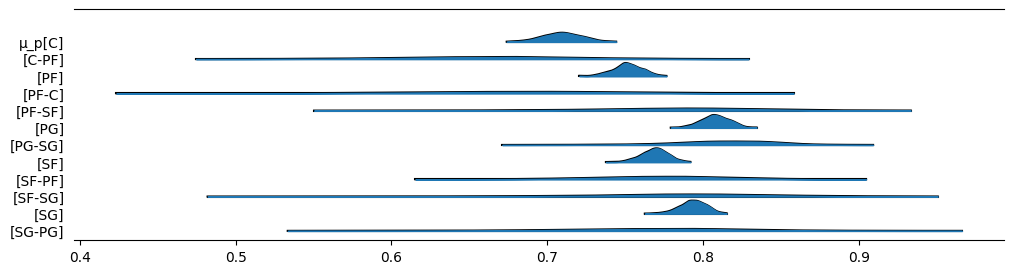

In [13]:
az.plot_forest(idata_bb, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)
az.rhat(idata_bb)

This seemed like it worked pretty good, the Rhat value is pretty reasonable, and the ridgeplot looks like it is working well for some positions. That being said, there are a number of positions that look like they are not functioning properly. Looking at the data again, some positions only shoot free throws a few times, which is not enough data for the model. In this next model I will remove the positions that do not shoot often, C-PF, PF-C, PF-SF, PG-SG, SF-PF, SF-SG, SG-PG.

In [10]:
#Only include positions that take free throws often
cbb_data = bb_data.query('Pos == "C" | Pos == "PF" | Pos == "PG" | Pos == "SF" | Pos == "SG"')

#Same proccessing as before, but with only the new set of positions
pos2_idx = cbb_data.Pos.cat.codes.values
pos2_codes = cbb_data.Pos.cat.categories
cbb_coords = {"pos": pos2_codes}

In [11]:
with pm.Model(coords = cbb_coords) as cbb_model:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos2_idx], nu = ν_p[pos2_idx])

    _ = pm.Binomial('gs',
                    n = cbb_data.FTA.values,
                    p = θ,
                    observed = cbb_data.FT.values)

    idata_cbb = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<xarray.Dataset> Size: 10kB
Dimensions:  (θ_dim_0: 572, pos: 12)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 5kB 0 1 2 3 4 5 6 7 ... 565 566 567 568 569 570 571
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    θ        (θ_dim_0) float64 5kB 0.9994 1.002 1.002 0.9999 ... 1.01 1.005 1.0
    μ        float64 8B 1.003
    μ_p      (pos) float64 96B 0.9994 1.001 1.004 1.003 ... 1.001 1.0 1.003
    ν        float64 8B 1.004
    ν_p      (pos) float64 96B 1.001 1.001 1.003 1.001 ... 1.002 1.001 0.9999

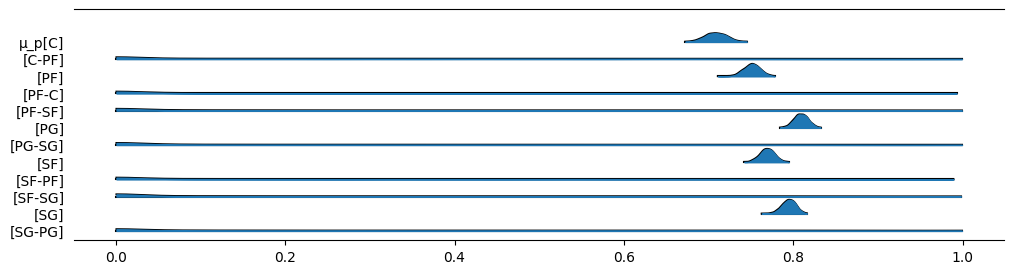

In [14]:
az.plot_forest(idata_cbb, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)
az.rhat(idata_bb)

This looks like it worked much better, the positions we know shoot free throws often seem to be even more centered around their values. I was not able to get the positions we cut out of the ridgeplot, but it does seem like this worked better regardless.